# TEDA (Typicality & Eccentricity Data Analysis) — Bootcamp Notebook

Neste notebook contém um passo a passo para aplicar o **TEDA** em séries temporais de energia annotadas (LEAD 1.0). 

Vamos abordar os seguintes tópicos:
1) carregamento e preparação dos dados;  
2) execução do TEDA (offline) com diferentes sensibilidades;  
3) comparação com rótulos de anomalia;  
4) visualizações (série temporal + sensibilidade ao parâmetro *m* + matriz de confusão).

> **Dica**: Execute as células na ordem. Os gráficos e CSVs são salvos no diretório atual.

## ⚙️ Requisitos

- Python 3.x  
- Bibliotecas: `pandas`, `numpy`, `matplotlib`, `scikit-learn`  
- Arquivos na mesma pasta do notebook:  
  - `lead1.0-small.csv`  
  - `teda.py` (contendo a classe `TEDA(threshold)` com `.run_offline(df, features)`)

> Se estiver em um ambiente novo, instale dependências:  
> `pip install pandas numpy matplotlib scikit-learn`

## 🔧 Parâmetros (edite aqui)

Escolha **prédio**, **janela temporal** e a **sensibilidade** do TEDA.  
Para a aula, você pode começar com um dos prédios/janelas sugeridos e variar `M_DEFAULT` e a lista `MS`.

> Quanto maior o `M_DEFAULT`, menos anomalias serão detectadas.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Parâmetros principais
BUILDING_ID = 263
START = "2016-01-16 00:00:00"
END   = "2016-01-18 23:59:59"

# Sensibilidade do TEDA
M_DEFAULT = 0.15
MS = [0.05, 0.10, 0.15, 0.20, 0.25]

# Arquivos
DATA_PATH = "./lead1.0-small.csv"

print(f"Config: building={BUILDING_ID}, window=({START} → {END}), m0={M_DEFAULT}, sweep={MS}")


Config: building=263, window=(2016-01-16 00:00:00 → 2016-01-18 23:59:59), m0=0.15, sweep=[0.05, 0.1, 0.15, 0.2, 0.25]


## 📥 Carregar dados e filtrar janela
- Convertemos `timestamp` para `datetime`.
- Filtramos pelo `BUILDING_ID` e pela janela `[START, END]`.

In [8]:

# 1) Carregar dados
df = pd.read_csv(DATA_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filtrar prédio e janela
mask = (
    (df["building_id"] == BUILDING_ID) &
    (df["timestamp"] >= pd.to_datetime(START)) &
    (df["timestamp"] <= pd.to_datetime(END))
)
df1 = df.loc[mask].copy()

print(df1.head())
print("Shape:", df1.shape)


       building_id           timestamp  meter_reading  anomaly
71531          263 2016-01-16 00:00:00          56.44        1
71731          263 2016-01-16 01:00:00          56.32        1
71930          263 2016-01-16 02:00:00          57.08        1
72130          263 2016-01-16 03:00:00          55.82        1
72330          263 2016-01-16 04:00:00          53.69        1
Shape: (72, 4)


## 🧠 Importar o TEDA
O arquivo `teda.py` deve estar no mesmo diretório. Ele precisa expor a classe `TEDA(threshold)` com o método `run_offline(df, features)`.

In [9]:

# 3) Importar TEDA
import teda

# Função utilitária para aplicar o TEDA
def apply_teda(g: pd.DataFrame, m: float) -> pd.DataFrame:
    g = g.sort_values("timestamp").reset_index(drop=True)
    work = g[["meter_reading"]].copy()
    model = teda.TEDA(threshold=m)
    model.run_offline(work, features=["meter_reading"])  # adiciona coluna 'is_outlier'
    g = g.copy()
    g["teda_outlier"] = work["is_outlier"].astype(int).values
    return g


## ▶️ Rodar TEDA (m = `M_DEFAULT`)
Calculamos também as métricas contra o rótulo `anomaly`.

In [10]:

# 4) Rodar TEDA (m = M_DEFAULT)
res = apply_teda(df1, m=M_DEFAULT)

# 5) Métricas
y_true = res["anomaly"].astype(int).values
y_pred = res["teda_outlier"].astype(int).values
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"[Prédio {BUILDING_ID} | {START} → {END} | m={M_DEFAULT}]")
print(f"Precisão={prec:.3f}  Revocação={rec:.3f}  F1={f1:.3f}")


[Prédio 263 | 2016-01-16 00:00:00 → 2016-01-18 23:59:59 | m=0.15]
Precisão=1.000  Revocação=0.944  F1=0.971


## 🧩 Matriz de confusão (m = `M_DEFAULT`)
Ajuda a interpretar o trade-off entre falsos positivos e falsos negativos.

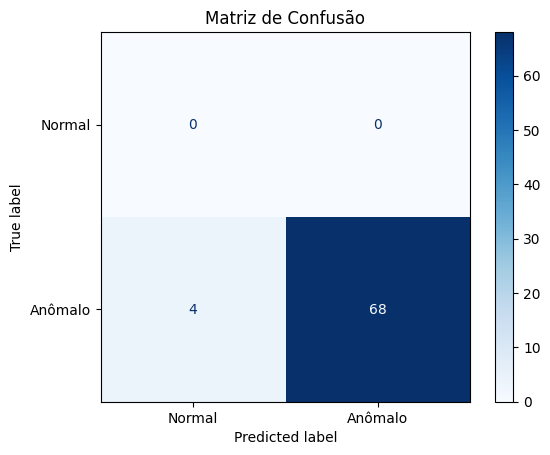

In [11]:
# plotar matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Normal", "Anômalo"])
disp.plot(values_format="d", cmap="Blues", colorbar=True)
plt.title("Matriz de Confusão")
plt.grid(False)
plt.show()

## 📈 Série temporal com rótulos e detecções do TEDA
Marcamos os rótulos (`anomaly=1`) e as detecções do TEDA.

<function matplotlib.pyplot.show(close=None, block=None)>

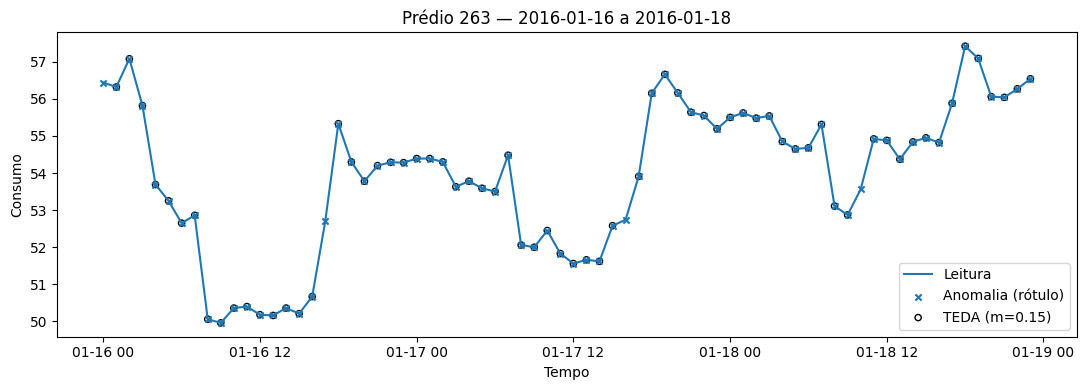

In [12]:

# 6) Série temporal
plt.figure(figsize=(11,4))
plt.plot(res["timestamp"], res["meter_reading"], label="Leitura")
plt.scatter(res.loc[res["anomaly"]==1, "timestamp"], res.loc[res["anomaly"]==1, "meter_reading"],
            marker="x", s=20, label="Anomalia (rótulo)", zorder=3)
plt.scatter(res.loc[res["teda_outlier"]==1, "timestamp"], res.loc[res["teda_outlier"]==1, "meter_reading"],
            facecolors="none", edgecolors="k", s=20, label=f"TEDA (m={M_DEFAULT})")
plt.title(f"Prédio {BUILDING_ID} — {START[:10]} a {END[:10]}")
plt.xlabel("Tempo"); plt.ylabel("Consumo")
plt.legend(); plt.tight_layout()
# plt.savefig(f"./serie_{BUILDING_ID}.png", dpi=180); plt.close()
# print("Figura salva:", f"./serie_{BUILDING_ID}.png")
plt.show

In [13]:

# 7) Sensibilidade ao m
rows = []
for m in MS:
    tmp = apply_teda(df, m=m)
    p_i, r_i, f1_i, _ = precision_recall_fscore_support(
        tmp["anomaly"].astype(int).values,
        tmp["teda_outlier"].astype(int).values,
        average="binary", zero_division=0
    )
    rows.append((m, p_i, r_i, f1_i))

scores = pd.DataFrame(rows, columns=["m","precision","recall","f1"])
print("Sensibilidade ao m:\n", scores)

plt.figure(figsize=(7,4))
plt.plot(scores["m"], scores["precision"], marker="o", label="Precisão")
plt.plot(scores["m"], scores["recall"], marker="o", label="Revocação")
plt.plot(scores["m"], scores["f1"], marker="o", label="F1")
plt.xlabel("m (sensibilidade)"); plt.ylabel("Score")
plt.title(f"Sensibilidade do TEDA — Prédio {BUILDING_ID}")
plt.legend(); plt.tight_layout()
# plt.savefig(f"./sens_m_{BUILDING_ID}.png", dpi=180); plt.close()
# print("Figura salva:", f"./sens_m_{BUILDING_ID}.png")
plt.show()

KeyboardInterrupt: 

## 💾 Salvar resultados por amostra
Inclui a coluna `teda_outlier` para análise posterior.

In [ ]:

# 9) Salvar CSV
res.to_csv(f"./teda_results_{BUILDING_ID}_{START[:10]}_{END[:10]}.csv", index=False)
print("CSV salvo:", f"./teda_results_{BUILDING_ID}_{START[:10]}_{END[:10]}.csv")


---

## 🔎 (Opcional) Descobrir automaticamente boas janelas para demonstração
Encontra janelas de 3 dias com **anomalias e variação** (evita séries “retas”). Edite os limiares para refinar.

In [ ]:

WINDOW_DAYS = 3
MIN_ANOMS   = 3
MIN_CV      = 0.02
MIN_UNIQUE  = 0.15

df_all = pd.read_csv(DATA_PATH)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"])
df_all = df_all.sort_values(["building_id","timestamp"])

def scan_building(df_b, window_days=WINDOW_DAYS):
    out = []
    days = pd.date_range(df_b["timestamp"].min().normalize(),
                         df_b["timestamp"].max().normalize(), freq="D")
    for start in days:
        end = start + pd.Timedelta(days=window_days) - pd.Timedelta(seconds=1)
        sel = (df_b["timestamp"] >= start) & (df_b["timestamp"] <= end)
        chunk = df_b.loc[sel].copy()
        if len(chunk) < 24:
            continue
        chunk = chunk.set_index("timestamp")
        chunk["meter_reading"] = chunk["meter_reading"].interpolate(method="time", limit_direction="both")
        chunk = chunk.reset_index()
        vals = chunk["meter_reading"].dropna().values
        if len(vals) == 0:
            continue
        mean = float(np.mean(vals))
        std  = float(np.std(vals))
        cv   = (std/mean) if mean != 0 else (np.inf if std>0 else 0.0)
        unique_ratio = pd.Series(vals).nunique() / len(vals)
        anoms = int(chunk["anomaly"].sum())
        if (anoms >= MIN_ANOMS) and (cv >= MIN_CV) and (unique_ratio >= MIN_UNIQUE):
            out.append({
                "building_id": int(df_b["building_id"].iloc[0]),
                "start": start, "end": end,
                "n_points": int(len(vals)),
                "anoms": anoms,
                "cv": round(cv, 4),
                "unique_ratio": round(unique_ratio, 3)
            })
    return out

anom_blds = df_all.loc[df_all["anomaly"]==1, "building_id"].unique().tolist()
cands = []
for b in anom_blds:
    cands.extend(scan_building(df_all[df_all["building_id"]==b].copy()))

cands = pd.DataFrame(cands).sort_values(["anoms","cv","unique_ratio"], ascending=[False, False, False]).reset_index(drop=True)
print("Top 10 janelas:")
cands.head(10)


Top 10 janelas:


,building_id,start,end,n_points,anoms,cv,unique_ratio
0,141,2016-12-27,2016-12-29 23:59:59,72,72,0.1428,0.514
1,190,2016-09-23,2016-09-25 23:59:59,72,72,0.0612,0.903
2,263,2016-01-16,2016-01-18 23:59:59,72,72,0.0366,0.944
3,254,2016-10-21,2016-10-23 23:59:59,72,69,1.3138,0.569
4,141,2016-12-28,2016-12-30 23:59:59,72,68,0.1427,0.583
5,653,2016-02-15,2016-02-17 23:59:59,72,68,0.1382,1.000
6,439,2016-12-24,2016-12-26 23:59:59,72,68,0.0591,1.000
7,1353,2016-11-23,2016-11-25 23:59:59,72,66,0.1898,0.639
8,1309,2016-07-17,2016-07-19 23:59:59,72,65,0.5202,0.222
9,190,2016-09-22,2016-09-24 23:59:59,72,65,0.3407,0.944



---

# 🏃 Exercícios rápidos

Use esta seção para praticar ajustes do TEDA, comparar prédios e investigar erros.  
**Dica:** execute as células anteriores primeiro (até gerar `apply_teda`, `df`, `BUILDING_ID`, etc.).



## 1) Ajuste fino do `m` (sensibilidade)
Altere `M_DEFAULT` e reavalie rapidamente as métricas para o mesmo prédio e janela.


In [ ]:

# TODO: ajuste aqui e rode
M_TRY = 0.08  # experimente: 0.03, 0.05, 0.08, 0.12, ...

res_try = apply_teda(df, m=M_TRY)
y_true = res_try["anomaly"].astype(int).values
y_pred = res_try["teda_outlier"].astype(int).values

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
print(f"[m={M_TRY}] Precisão={prec:.3f} | Revocação={rec:.3f} | F1={f1:.3f}")


[m=0.08] Precisão=1.000 | Revocação=0.972 | F1=0.986



## 2) Busca de `m` ótimo por F1 (grid simples)
Varra vários valores de `m` e escolha o melhor por F1 para **este prédio/janela**.


In [ ]:

m_grid = np.linspace(0.02, 0.20, 13)  # 0.02, 0.04, ..., 0.20
rows = []
for m in m_grid:
    tmp = apply_teda(df, m=float(m))
    p_i, r_i, f1_i, _ = precision_recall_fscore_support(
        tmp["anomaly"].astype(int).values,
        tmp["teda_outlier"].astype(int).values,
        average="binary",
        zero_division=0
    )
    rows.append((float(m), p_i, r_i, f1_i))
grid_scores = pd.DataFrame(rows, columns=["m","precision","recall","f1"]).sort_values("f1", ascending=False)
grid_scores.head(10)

,m,precision,recall,f1
0,0.020,1.0,0.972222,0.985915
1,0.035,1.0,0.972222,0.985915
2,0.050,1.0,0.972222,0.985915
3,0.065,1.0,0.972222,0.985915
4,0.080,1.0,0.972222,0.985915
5,0.095,1.0,0.972222,0.985915
6,0.110,1.0,0.958333,0.978723
7,0.125,1.0,0.944444,0.971429
8,0.140,1.0,0.944444,0.971429
9,0.155,1.0,0.944444,0.971429



## 3) Comparar dois prédios
Escolha um **segundo prédio** com a respectiva janela de tempo e compare métricas/curvas.


| building_id | start       | end                  | n_points | anoms |    cv   | unique_ratio |
|-------------|-------------|----------------------|----------|-------|---------|--------------|
| 141         | 2016-12-27  | 2016-12-29 23:59:59   | 72       | 72    | 0.1428  | 0.514        |
| 190         | 2016-09-23  | 2016-09-25 23:59:59   | 72       | 72    | 0.0612  | 0.903        |
| 263         | 2016-01-16  | 2016-01-18 23:59:59   | 72       | 72    | 0.0366  | 0.944        |
| 254         | 2016-10-21  | 2016-10-23 23:59:59   | 72       | 69    | 1.3138  | 0.569        |
| 141         | 2016-12-28  | 2016-12-30 23:59:59   | 72       | 68    | 0.1427  | 0.583        |
| 653         | 2016-02-15  | 2016-02-17 23:59:59   | 72       | 68    | 0.1382  | 1.000        |
| 439         | 2016-12-24  | 2016-12-26 23:59:59   | 72       | 68    | 0.0591  | 1.000        |
| 1353        | 2016-11-23  | 2016-11-25 23:59:59   | 72       | 66    | 0.1898  | 0.639        |
| 1309        | 2016-07-17  | 2016-07-19 23:59:59   | 72       | 65    | 0.5202  | 0.222        |
| 190         | 2016-09-22  | 2016-09-24 23:59:59   | 72       | 65    | 0.3407  | 0.944        |

In [ ]:

# TODO: escolha um prédio 2 com anomalias na mesma janela START–END
BUILDING_ID_2 = BUILDING_ID  # troque para outro ID (Vejam a tabela)
START = START
END = END

# df = pd.read_csv(DATA_PATH)
# df["timestamp"] = pd.to_datetime(df["timestamp"])

# Filtrar o segundo prédio
mask2 = (
    (df1["building_id"] == BUILDING_ID_2) &
    (df1["timestamp"] >= pd.to_datetime(START)) &
    (df1["timestamp"] <= pd.to_datetime(END))
)
df2 = df1.loc[mask2].copy().sort_values("timestamp")
df2 = df2.reset_index()

# Rodar TEDA em ambos com o mesmo m
res1 = apply_teda(df1,  m=M_DEFAULT)    # prédio 1 (já filtrado anteriormente)
res2 = apply_teda(df2, m=M_DEFAULT)    # prédio 2

def metrics_of(res):
    y_true = res["anomaly"].astype(int).values
    y_pred = res["teda_outlier"].astype(int).values
    return precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[:3]

p1, r1, f1 = metrics_of(res1)
p2, r2, f2 = metrics_of(res2)

print(f"Prédio {BUILDING_ID}:  P={p1:.3f} R={r1:.3f} F1={f1:.3f}")
print(f"Prédio {BUILDING_ID_2}: P={p2:.3f} R={r2:.3f} F1={f2:.3f}")


Prédio 263:  P=1.000 R=0.944 F1=0.971
Prédio 263: P=1.000 R=0.944 F1=0.971



## 4) Investigue **FP** e **FN**
Liste timestamps onde o TEDA aponta outlier mas o rótulo é 0 (FP) e onde o rótulo é 1 mas o TEDA não detecta (FN).


In [ ]:

res_dbg = res.copy()
res_dbg["FP"] = ((res_dbg["teda_outlier"]==1) & (res_dbg["anomaly"]==0)).astype(int)
res_dbg["FN"] = ((res_dbg["teda_outlier"]==0) & (res_dbg["anomaly"]==1)).astype(int)

print("Falsos positivos (primeiros 10):")
display(res_dbg.loc[res_dbg["FP"]==1, ["timestamp","meter_reading","anomaly","teda_outlier"]].head(10))

print("Falsos negativos (primeiros 10):")
display(res_dbg.loc[res_dbg["FN"]==1, ["timestamp","meter_reading","anomaly","teda_outlier"]].head(10))


Falsos positivos (primeiros 10):


,timestamp,meter_reading,anomaly,teda_outlier


Falsos negativos (primeiros 10):


,timestamp,meter_reading,anomaly,teda_outlier
0,2016-01-16 00:00:00,56.44,1,0
17,2016-01-16 17:00:00,52.70,1,0
40,2016-01-17 16:00:00,52.74,1,0
58,2016-01-18 10:00:00,53.56,1,0
